# Homework-3. UserKnn для горячих пользователей


In [ ]:
!pip install rectools==0.3.0

# Загрузка датасета KION

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import requests
from tqdm.auto import tqdm
from scipy.stats import mode 
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")

# from rectools import Columns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)

# download dataset by chunks
url = "https://storage.yandexcloud.net/itmo-recsys-public-data/kion_train.zip"

req = requests.get(url, stream=True)

with open('kion_train.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

!unzip kion_train.zip

interactions = pd.read_csv('kion_train/interactions.csv')
users = pd.read_csv('kion_train/users.csv')
items = pd.read_csv('kion_train/items.csv')

# rename columns, convert timestamp
interactions.rename(columns={'last_watch_dt': "datetime"}, inplace=True) 
interactions['datetime'] = pd.to_datetime(interactions['datetime'])

interactions["user_id"] = interactions["user_id"].astype(np.uint32)
interactions["item_id"] = interactions["item_id"].astype(np.uint16)
interactions["total_dur"] = interactions["total_dur"].astype(np.uint16)
interactions["watched_pct"] = interactions["watched_pct"].astype(np.float32)

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

Archive:  kion_train.zip
   creating: kion_train/
  inflating: kion_train/interactions.csv  
  inflating: __MACOSX/kion_train/._interactions.csv  
  inflating: kion_train/users.csv    
  inflating: __MACOSX/kion_train/._users.csv  
  inflating: kion_train/items.csv    
  inflating: __MACOSX/kion_train/._items.csv  


In [2]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   user_id      uint32        
 1   item_id      uint16        
 2   datetime     datetime64[ns]
 3   total_dur    uint16        
 4   watched_pct  float32       
dtypes: datetime64[ns](1), float32(1), uint16(2), uint32(1)
memory usage: 104.5 MB


# Модели и бейзлайны

## 0. Деление пользователей на горячих

Горячие пользователи - это те пользователи, у которых 10 или больше взаимодействий.  Решили убрать тёплых пользователей, у которых мало взаимодействий.

Получим 145_410 уникальных горячих пользователей 


In [3]:
# Preparing of the Hot Users
threshold = 10
users_inter_count = interactions.groupby("user_id")["item_id"].count()
hot_users = users_inter_count[users_inter_count >= threshold].index.values

hot_interactions = interactions[interactions["user_id"].isin(hot_users)].sort_values(["user_id", "datetime"])
hot_interactions["order"] = hot_interactions.groupby("user_id").cumcount(ascending=False)
hot_interactions["order"] = hot_interactions["order"].astype(np.uint16)

print("Hot users: ", hot_users.shape[0])
print("Hot interactions: ", hot_interactions.shape[0])
hot_interactions.tail(12)

Hot users:  145410
Hot interactions:  3260927


,user_id,item_id,datetime,total_dur,watched_pct,order
537061,1097544,13973,2021-08-21,3089,58.0,1
5157263,1097544,1000,2021-08-21,67,1.0,0
3622193,1097554,11275,2021-04-06,7825,100.0,9
1497465,1097554,1053,2021-04-10,12,100.0,8
4150064,1097554,849,2021-04-12,6521,100.0,7
4840760,1097554,9169,2021-04-14,7378,100.0,6
4450562,1097554,3509,2021-04-15,14076,100.0,5
1474297,1097554,496,2021-04-20,2,0.0,4
3818420,1097554,4580,2021-04-20,22404,100.0,3
885465,1097554,16361,2021-04-22,6662,100.0,2


Тёплые пользователи

In [4]:
# Preparing of the warm users
warm_users = users_inter_count[users_inter_count < threshold].index.values
warm_interaсtions = interactions[interactions["user_id"].isin(warm_users)].sort_values(["user_id", "datetime"])
print("Warm users: ", warm_users.shape[0])
print("Warm interactions: ", warm_interaсtions.shape[0])
warm_interaсtions.head(12)

Warm users:  816769
Warm interactions:  2215324


,user_id,item_id,datetime,total_dur,watched_pct
3590116,0,12192,2021-07-16,89,0.0
620,0,7102,2021-07-19,169,3.0
67070,0,14359,2021-07-19,130,2.0
90113,0,15297,2021-07-19,459,0.0
3103040,0,9728,2021-07-19,4,0.0
1213765,0,6006,2021-07-20,1,0.0
2354936,1,10440,2021-08-13,19579,80.0
1625374,1,3669,2021-08-16,1593,26.0
4299412,4,6317,2021-06-02,14,0.0
114632,4,4700,2021-07-02,5799,97.0


## 1. Горячие пользователи UserKnn


В этом пункте произведём оценку моделей CosineRecommender, TFIDFRecommender, BM25Recommender на выборке горячих пользователей

Схему валидации - UsersKFoldPOut, оставляем в тесте P последних просмотров пользователя (P=5)

#### 1.1. Дополненная UserKnn с лекции

Изменили UserKnn модель с семинара:

1. Теперь матрица весов взаимодействий может принимать не только факт взаимодействия, но и длительность просмотра или процент просмотренного

2. Теперь происходит корректное удаление самого себя из похожих

3. Теперь мы не рекомендуем айтемы, которые пользователь уже просмотрел

In [9]:
import pandas as pd
import numpy as np
import scipy as sp
import dill
from typing import Dict, Optional
from collections import Counter
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender
from rectools.metrics import Precision, Recall, MAP, MeanInvUserFreq, Serendipity, calc_metrics
from rectools import Columns


class UserKnn():
    """Class for fit-perdict UserKNN model 
       based on ItemKNN model from implicit.nearest_neighbours
    """
    
    def __init__(self, model: ItemItemRecommender, N_users: int = 50):
        self.N_users = N_users
        self.model = model
        self.is_fitted = False
        
    def get_mappings(self, train):
        self.users_inv_mapping = dict(enumerate(train['user_id'].unique()))
        self.users_mapping = {v: k for k, v in self.users_inv_mapping.items()}
        
        self.items_inv_mapping = dict(enumerate(train['item_id'].unique()))
        self.items_mapping = {v: k for k, v in self.items_inv_mapping.items()}
    
    def get_matrix(self, df: pd.DataFrame, 
                   user_col: str = 'user_id', 
                   item_col: str = 'item_id', 
                   weight_col: str = None, 
                   users_mapping: Dict[int, int] = None, 
                   items_mapping: Dict[int, int] = None):

        if weight_col:
            weights = df[weight_col].astype(np.float32)
        else:
            weights = np.ones(len(df), dtype=np.float32)

        interaction_matrix = sp.sparse.coo_matrix((
            weights,
            (
                df[user_col].map(self.users_mapping.get),
                df[item_col].map(self.items_mapping.get)
            )
            ))

        self.watched = df.groupby(user_col).agg({item_col: tuple})
        return interaction_matrix

    def idf(self, n: int, x: float):
        return np.log((1 + n) / (1 + x) + 1)

    def _count_item_idf(self, df: pd.DataFrame):
        item_cnt = Counter(df['item_id'].values)
        item_idf = pd.DataFrame.from_dict(item_cnt, orient='index', columns=['doc_freq']).reset_index()
        item_idf['idf'] = item_idf['doc_freq'].apply(lambda x: self.idf(self.n, x))
        self.item_idf = item_idf

    # 1) добавили аргумент weight_col = None, теперь можно выбирать что есть вес
    def fit(self, train: pd.DataFrame, weight_col: Optional[str] = None):
        self.user_knn = self.model
        self.get_mappings(train)
        # 2) Тут не был задан параметр weight_col=
        self.weights_matrix = self.get_matrix(train, weight_col=weight_col, 
                                              users_mapping=self.users_mapping, 
                                             items_mapping=self.items_mapping)

        self.n = train.shape[0]

        # 3) Оставили idf для переранжирования айтемов 
        self._count_item_idf(train)

        self.user_knn.fit(self.weights_matrix)
        self.is_fitted = True

    def _generate_recs_mapper(self, model: ItemItemRecommender, user_mapping: Dict[int, int], 
                              user_inv_mapping: Dict[int, int], N: int):
        def _recs_mapper(user):
            user_id = user_mapping[user]
            recs = model.similar_items(user_id, N=N)
            return [user_inv_mapping[user] for user, _ in recs], [sim for _, sim in recs]
        return _recs_mapper
    
    def predict(self, user_id: pd.DataFrame, N_recs: int = 10):
        
        if not self.is_fitted:
            raise ValueError("Please call fit before predict")
        
        mapper = self._generate_recs_mapper(
            model=self.user_knn, 
            user_mapping=self.users_mapping,
            user_inv_mapping=self.users_inv_mapping,
            N=self.N_users
        )

        recs = pd.DataFrame({'user_id': user_id["user_id"].unique()})
        recs['sim_user_id'], recs['sim'] = zip(*recs['user_id'].map(mapper))
        recs = recs.set_index('user_id').apply(pd.Series.explode).reset_index()
        recs["sim_user_id"] = recs["sim_user_id"].astype(np.uint32)
        recs["sim"] = recs["sim"].astype(np.float32)
        # 4) Удаляем самого себя из похожих
        recs = recs[recs["user_id"] != recs["sim_user_id"]] 
        
        recs = recs.merge(self.watched, left_on=['sim_user_id'], right_on=['user_id'], how='left')\
                    .drop(["sim_user_id"], axis=1)\
                    .explode('item_id')\
                    .sort_values(['user_id', 'sim'], ascending=False)\
                    .drop_duplicates(['user_id', 'item_id'], keep='first')\
                    .merge(self.watched, left_on=["user_id"], right_on=["user_id"], how="left")
        
        # 5) исключаем уже просмотренное тестовым пользователем из рекомендаций
        recs = recs[recs.apply(lambda x: x["item_id_x"] not in x["item_id_y"], axis=1)]\
                    .rename(columns={"item_id_x": "item_id"})\
                    .merge(self.item_idf, left_on='item_id', right_on='index', how='left')
        
        recs['score'] = recs['sim'] * recs['idf']
        recs.drop(["sim", "idf"], axis=1, inplace=True)
        recs = recs.sort_values(['user_id', 'score'], ascending=False)
        recs['rank'] = recs.groupby('user_id').cumcount() + 1
        return recs[recs['rank'] <= N_recs][['user_id', 'item_id', 'rank']]


#### 1.2. Схема валидации



Крос-валидацию UsersKFoldPOut. Выбрали такую валидацию, а не по времени, потому что матрица вазаимодействий не учитывает временные признаки.

Лучшую модель обучим на всём нашем наборе горячих пользователей, а далее отправим модель на сервис.

In [ ]:
class UsersKFoldPOut():
    def __init__(
        self, n_folds: int, p: int, 
        user_column: str = "user_id", 
        order_column: str = "order", 
        random_seed: int = 23
    ):
        self.n_folds = n_folds
        self.p = p
        self.user_column = user_column
        self.order_column = order_column
        self.random_seed = random_seed

    def split(self, df: pd.DataFrame):
        # сортировка для воспроизводимости результатов
        users = sorted(df[self.user_column].unique())
        users_count = len(users)

        np.random.seed(self.random_seed)
        np.random.shuffle(users)

        fold_sizes = np.full(self.n_folds, users_count // self.n_folds, dtype=np.uint32)
        fold_sizes[: users_count % self.n_folds] += 1
        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            test_fold_users = users[start:stop]
            test_mask = df[self.user_column].isin(test_fold_users) & (df[self.order_column] < self.p)
            train_mask =df[self.user_column].isin(test_fold_users) & ~test_mask

            yield train_mask, test_mask
            current = stop


def train(
    df: pd.DataFrame,
    cv: UsersKFoldPOut,
    models: dict,
    metrics: dict,
    weight_col: Optional[str] = None,
):
    results = []

    fold_iterator = cv.split(df)

    postfix = weight_col
    if not weight_col:
        postfix = "weight_1"

    for i_fold, (train_ids, test_ids) in enumerate(fold_iterator):
        print(f"\n==================== Fold {i_fold}")

        df_train = df.loc[train_ids].copy()
        df_test = df.loc[test_ids][Columns.UserItem].copy()

        catalog = df_train[Columns.Item].unique()
        
        for model_name, model in models.items():
            userknn_model = UserKnn(model=model, N_users=50)
            userknn_model.fit(df_train, weight_col=weight_col)
        
            recos = userknn_model.predict(df_test)
        
            metric_values = calc_metrics(
                metrics,
                reco=recos,
                interactions=df_test,
                prev_interactions=df_train,
                catalog=catalog,
            )
    
            fold = {"fold": i_fold, "model": model_name}
            fold.update(metric_values)
            results.append(fold)

    df_metrics = pd.DataFrame(results)
    df_metrics.to_csv(f"/content/drive/MyDrive/RecSys MTC/practice3/models/df_metrics_{postfix}.csv")

#### 1.3. Сравнение и выбор модели

Рассмотрим три модели UserKnn и три варианта весов матрицы взаимодействий (факт просмотра, длительность и процент)

In [ ]:
metrics = {
    "prec@10": Precision(k=10),
    "recall@10": Recall(k=10),
    "map@10": MAP(k=10),
    "novelty": MeanInvUserFreq(k=10),
    "serendipity": Serendipity(k=10),
}

models = {
    "cosine": CosineRecommender(),
    "tfidf": TFIDFRecommender(),
    "bm25": BM25Recommender(),
}

cv = UsersKFoldPOut(n_folds=10, p=5)

train(hot_interactions, cv, models, metrics, weight_col=None)
train(hot_interactions, cv, models, metrics, weight_col="watched_pct")
train(hot_interactions, cv, models, metrics, weight_col="total_dur")

Результаты показывают, что BM25Recommender с процентом просмотра даёт лучшие метрики:


1) факт взаимодействия с айтемом

In [ ]:
# Вес матрицы = Факт взаимодействия 
df_metrics_w1 = pd.read_csv(f"/content/drive/MyDrive/RecSys MTC/practice3/models/df_metrics_weight_1.csv")
df_metrics_w1.groupby("model").mean()[metrics.keys()]

,prec@10,recall@10,map@10,novelty,serendipity
model,,,,,
bm25,0.004339,0.008678,0.002416,10.149643,0.000135
cosine,0.004510,0.009020,0.002368,9.181425,0.000124
tfidf,0.008577,0.017154,0.005005,8.666940,0.000186


In [ ]:
df_metrics_w1.groupby("model").std()[metrics.keys()]

,prec@10,recall@10,map@10,novelty,serendipity
model,,,,,
bm25,0.000127,0.000254,0.000179,0.024767,0.000006
cosine,0.000230,0.000459,0.000217,0.029144,0.000008
tfidf,0.000380,0.000759,0.000295,0.016193,0.000009


2) процент просмотра айтема 

In [ ]:
# Вес матрицы = Процент просмотра
df_metrics_wpct = pd.read_csv(f"/content/drive/MyDrive/RecSys MTC/practice3/models/df_metrics_watched_pct.csv")
df_metrics_wpct.groupby("model").mean()[metrics.keys()]

,prec@10,recall@10,map@10,novelty,serendipity
model,,,,,
bm25,0.011802,0.023605,0.008089,7.136264,0.000071
cosine,0.002658,0.005316,0.001351,9.675353,0.000074
tfidf,0.005205,0.010409,0.002777,8.989649,0.000128


In [ ]:
df_metrics_wpct.groupby("model").std()[metrics.keys()]

,prec@10,recall@10,map@10,novelty,serendipity
model,,,,,
bm25,0.000307,0.000615,0.000201,0.029986,0.000004
cosine,0.000212,0.000425,0.000144,0.060839,0.000008
tfidf,0.000236,0.000473,0.000202,0.017995,0.000008


3) длительность просмотра

In [ ]:
# Вес матрицы = Длительность просмотра
df_metrics_dur = pd.read_csv(f"/content/drive/MyDrive/RecSys MTC/practice3/models/df_metrics_total_dur.csv")
df_metrics_dur.groupby("model").mean()[metrics.keys()]

,prec@10,recall@10,map@10,novelty,serendipity
model,,,,,
bm25,0.000710,0.001421,0.000405,12.389601,0.000026
cosine,0.001772,0.003544,0.000917,10.289630,0.000053
tfidf,0.003760,0.007519,0.001979,9.349572,0.000101


In [ ]:
df_metrics_dur.groupby("model").std()[metrics.keys()]

,prec@10,recall@10,map@10,novelty,serendipity
model,,,,,
bm25,0.000100,0.000201,0.000049,0.156868,0.000004
cosine,0.000142,0.000285,0.000075,0.061141,0.000004
tfidf,0.000148,0.000295,0.000120,0.021250,0.000006


#### 1.4. Выбор модели для сервиса. Обучение на полном наборе горячих пользователей

Лучшая модель по результатам кросс-валидации - это:

**BM25Recommender с процентом просмотренного "watched_pct"** в весах разреженной матрицы взаимодействий.


##### 1.4.1. Оффлайн модель

Лидерборд:
- Название оффлайн модели "knn" 
- Результат MAP@10 = 0.086 ([сслыка лидерборд](https://docs.google.com/spreadsheets/d/1G_VQe_1S7Y0R5RvR7FJf0p34_loP-NCz5jg2iBAJrNo/edit#gid=2118880239))

In [8]:
"""
    Обучение модели UserKnn для Оффлайн рекомендаций
"""

# Берем 20 ближайших пользователей, так модель весит 86Mb (при 50 - вес модели равен 137Mb)
k_users = 20
offline_model = UserKnn(model=BM25Recommender(K=k_users, K1=1.2, B=0.75), N_users=k_users)

offline_model.fit(hot_interactions[["user_id", "item_id", "watched_pct"]], weight_col="watched_pct")

save_name = f"offline_model"
with open(f'/content/drive/MyDrive/RecSys MTC/practice3/models/{save_name}.dill', 'wb') as f:
    dill.dump(offline_model, f)

  0%|          | 0/145410 [00:00<?, ?it/s]

In [17]:
print("Количество горячих пользователей ", len(hot_users))
print(hot_users)

Количество горячих пользователей  145410
[      2       3       5 ... 1097534 1097544 1097554]


In [19]:
"""
    Формирование оффлайн рекомендаций для всех горячих пользователей
"""

offline_recs_df = []
# делим 145_410 пользователей на 10 частей, чтобы уложиться по памяти
hot_users_parts = np.split(hot_users, 10)
for users_part in hot_users_parts:
    # самая долгая операция в .predict(...) это apply, которая
    #  удаляет уже просмотренные айтемы
    # к сожалению, обойти и не использовать apply не получилось
    recs = offline_model.predict(pd.DataFrame(data={"user_id": users_part}))
    offline_recs_df.append(recs)
offline_recs_df = pd.concat(offline_recs_df)

offline_recs_df

,user_id,item_id,rank
0,110547,11118,1
1,110547,11899,2
2,110547,761,3
3,110547,7014,4
4,110547,12544,5
...,...,...,...
6852094,987882,4740,6
6852095,987882,7851,7
6852096,987882,10077,8
6852097,987882,15997,9


Сохраняем словарь с оффлайн рекомендациями в файл ```offline-dictionary-with-hot-knn-recs.dill```:

In [24]:
"""
    Сохранение словаря {user_id: List[item_id]}
    Его будем использовать в сервисе
"""

temp = offline_recs_df[["user_id", "item_id"]].groupby("user_id").agg(list).reset_index()
offline_dictionary_with_hot_knn_recs = dict(zip(temp["user_id"], temp["item_id"]))
with open("/content/drive/MyDrive/RecSys MTC/practice3/models/offline-dictionary-with-hot-knn-recs.dill", "wb") as f:
    dill.dump(offline_dictionary_with_hot_knn_recs, f)

##### 1.4.2. Онлайн модель

Лидерборд:
- Название онлайн модели "online_knn" 
- Результат MAP@10 = 0.095 ([сслыка лидерборд](https://docs.google.com/spreadsheets/d/1G_VQe_1S7Y0R5RvR7FJf0p34_loP-NCz5jg2iBAJrNo/edit#gid=2118880239))

Уже после формирования оффлайн рекомендаций мы заметили, что BM25Recommeder выдаёт только похожих пользоватателей без оценки их близости, поэтому мы изменили класс UserKnn для использования на сервисе в качестве Онлайн модели:

1. Теперь на вход функции ```predict``` подаётся ```int``` вместо ```DataFrame``` и рассматриваются только ```sim_user_id``` без меры близости к запрашиваемому пользователю. От чего уменьшилось количество операций сортировки

2. Теперь мы предлагаем Топ-10 популярных айтемов, которые пользователь не смотрел, но смотрели похожие на него пользователи

3. Используем импорты внутри самих функций для того, чтобы можно было импортировать модель на сервер и загружать с помощью ```dill```

In [30]:
class UserKnnBM25():
    """Class for fit-perdict UserKNN model 
       based on ItemKNN model from implicit.nearest_neighbours
    """
    from pandas import DataFrame
    from scipy.sparse import coo_matrix
    from numpy import log, ones, float32, array
    from collections import Counter
    from implicit.nearest_neighbours import BM25Recommender
    from typing import Dict, Optional

    def __init__(self, model: BM25Recommender, N_users: int = 50):
        self.N_users = N_users
        self.model = model
        self.is_fitted = False
        
    def get_mappings(self, train):
        self.users_inv_mapping = dict(enumerate(train['user_id'].unique()))
        self.users_mapping = {v: k for k, v in self.users_inv_mapping.items()}
        
        self.items_inv_mapping = dict(enumerate(train['item_id'].unique()))
        self.items_mapping = {v: k for k, v in self.items_inv_mapping.items()}
    
    def get_matrix(self, df: DataFrame, 
                   user_col: str = 'user_id', 
                   item_col: str = 'item_id', 
                   weight_col: str = None, 
                   users_mapping: Dict[int, int] = None, 
                   items_mapping: Dict[int, int] = None):
        from scipy.sparse import coo_matrix
        from numpy import ones, float32

        if weight_col:
            weights = df[weight_col].astype(float32)
        else:
            weights = ones(len(df), dtype=float32)

        interaction_matrix = coo_matrix((
            weights,
            (
                df[user_col].map(self.users_mapping.get),
                df[item_col].map(self.items_mapping.get)
            )
            ))

        self.watched = df.groupby(user_col).agg({item_col: tuple})
        return interaction_matrix

    def idf(self, n: int, x: float):
        from numpy import log
        return log((1 + n) / (1 + x) + 1)

    def _count_item_idf(self, df: DataFrame):
        from collections import Counter
        from pandas import DataFrame
        item_cnt = Counter(df['item_id'].values)
        item_idf = DataFrame.from_dict(item_cnt, orient='index', columns=['doc_freq']).reset_index()
        item_idf['idf'] = item_idf['doc_freq'].apply(lambda x: self.idf(self.n, x))
        self.item_idf = item_idf

    def fit(self, train: DataFrame, weight_col: Optional[str] = None):
        self.user_knn = self.model
        self.get_mappings(train)
        self.weights_matrix = self.get_matrix(train, weight_col=weight_col, 
                                              users_mapping=self.users_mapping, 
                                             items_mapping=self.items_mapping)

        self.n = train.shape[0]

        self._count_item_idf(train)

        self.user_knn.fit(self.weights_matrix)
        self.is_fitted = True

    def _get_similar_users(self, user_id: int, model: ItemItemRecommender, user_mapping: Dict[int, int],
                           user_inv_mapping: Dict[int, int], N_users: int) -> array:
        from numpy import array, isnan
        internal_user_id = user_mapping[user_id]
        sim_users = array(model.similar_items(internal_user_id, N=N_users))[:,0]
        sim_users = sim_users[~isnan(sim_users)].astype("uint32")
        return [user_inv_mapping[user] for user in sim_users]
    
    def predict(self, user_id: int, N_recs: int = 10):
        if not self.is_fitted:
            raise ValueError("Please call fit before predict")
        if user_id not in self.users_mapping:
            return None
        
        from pandas import DataFrame

        sim_users = self._get_similar_users(
            user_id=user_id,
            model=self.user_knn, 
            user_mapping=self.users_mapping,
            user_inv_mapping=self.users_inv_mapping,
            N_users=self.N_users
        )

        recs = DataFrame({
            "user_id": user_id,
            "sim_user_id": sim_users,
        })
        
        recs = recs.merge(self.watched, left_on=['sim_user_id'], right_on=['user_id'], how='left')\
                    .drop(["sim_user_id"], axis=1)\
                    .explode('item_id')\
                    .drop_duplicates(['item_id'], keep='first')\
                    .merge(self.watched, left_on=["user_id"], right_on=["user_id"], how="left")

        # исключаем уже просмотренное тестовым пользователем из рекомендаций
        recs = recs[recs.apply(lambda x: x["item_id_x"] not in x["item_id_y"], axis=1)]\
                    .drop(["item_id_y"], axis=1)\
                    .merge(self.item_idf, left_on='item_id_x', right_on='index', how='left')
        # предлагаем популярные айтемы, которые пользователь не смотрел, 
        # но смотрели похожие на него пользователи 
        recs = recs.sort_values(['idf'], ascending=True)
        return recs["item_id_x"][:N_recs].tolist()


Обучаем и сохраняем модель:

In [29]:
"""
    Обучение модели UserKnnBM25 для Онлайн рекомендаций
"""

k_users = 20
online_model = UserKnnBM25(model=BM25Recommender(K=k_users, K1=1.2, B=0.75), N_users=k_users)

online_model.fit(hot_interactions[["user_id", "item_id", "watched_pct"]], weight_col="watched_pct")

save_name = f"online_model"
with open(f'/content/drive/MyDrive/RecSys MTC/practice3/models/{save_name}.dill', 'wb') as f:
    dill.dump(online_model, f)

  0%|          | 0/145410 [00:00<?, ?it/s]

#### 1.5. Анализ скорости ответов у онлайн модели

In [33]:
%timeit online_model.predict(2)

123 ms ± 5.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
%timeit offline_model.predict(pd.DataFrame(data={"user_id": [2]}))

135 ms ± 3.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Онлайн модель (UserKnnBM25) немного быстрее, чем модель, использовавшаяся для генерации оффлайн рекомендаций (UserKnn).

С помощью скрипта замерили скорость на самом сервере. Время поиска рекомендаций для одного пользователя приблизительно равняется 70 ms:

    import timeit
    with open(f'service/reco_models/user-knn.dill', 'rb') as f:
        online_model = dill.load(f)
    print(timeit.timeit('online_model.predict(2)', "from __main__ import online_model", number=1)

В логах такая же информация: 
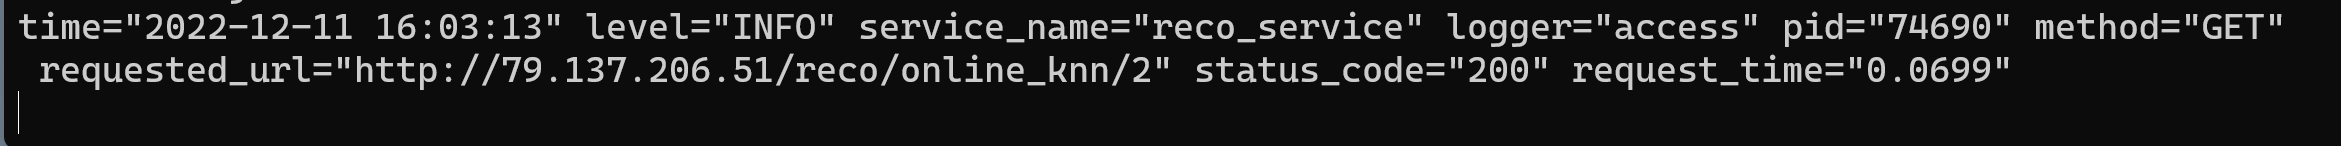

#### 1.6. Анализ нагрузки на наш сервис

In [43]:
import time
import requests
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt

In [62]:
URL = "http://79.137.206.51/reco/online_knn/{user_id}"
batch_sizes = [50 * i for i in range(1, 9)]

In [63]:
def make_request(user_id):
    url = URL.format(user_id=user_id)
    ts = time.perf_counter()
    resp = requests.get(url, headers={"Authorization": "Bearer Team_5"}, timeout=10)
    elapsed = time.perf_counter() - ts
    return elapsed

In [64]:
%time
full_times = []

for batch_size in tqdm(batch_sizes):
    ts = time.time()
    with ThreadPoolExecutor(batch_size) as p:
        users = range(batch_size)
        futures = p.map(make_request, users)
        results = list(futures)
    elapsed = time.time() - ts
    full_times.append(elapsed)
    time.sleep(1)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 129 µs


  0%|          | 0/8 [00:00<?, ?it/s]

Text(0.5, 0, 'Количество пользователей в пакете')

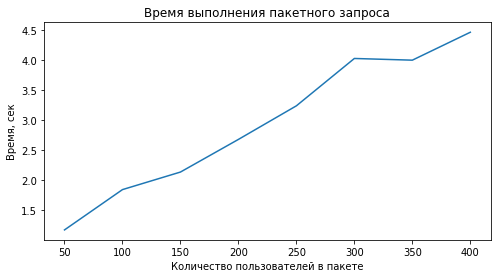

In [65]:
plt.rcParams["figure.figsize"] = 8, 4
plt.plot(batch_sizes, full_times)
plt.title("Время выполнения пакетного запроса")
plt.ylabel("Время, сек")
plt.xlabel("Количество пользователей в пакете")

# Смотрим 👀 на рекомендации

In [ ]:
offline_recs_df.merge(items[["item_id", "title", "countries"]], how="left", on="item_id").tail(30)

,user_id,item_id,rank,title,countries
1454070,987887,6192,1,Отчаянные домохозяйки,США
1454071,987887,14703,2,Денежная игла,США
1454072,987887,7571,3,100% волк,"Австралия, Бельгия"
1454073,987887,1465,4,Кошмары музыкантов,Россия
1454074,987887,11495,5,След оборотня,"Россия, Украина"
1454075,987887,12994,6,Человек без гравитации,"Италия, Бельгия"
1454076,987887,11134,7,Конверт,Россия
1454077,987887,181,8,Шиза,"Казахстан, Россия, Франция"
1454078,987887,8580,9,Один на один,США
1454079,987887,13029,10,Бешеный Пёс и Глори,США
